# Topic Clustering Using Latent Dirchlet Allocation

**Set path:**

In [1]:
import os
import sys
PATH = '/home/piotr/projects/twitter'
PATH_DATA = os.path.join(PATH, 'data/clean/')
PATH_RESULTS = os.path.join(PATH, 'results/topics')
PATH_EMBEDDINGS = '/home/piotr/nlp/cc.pl.300.vec'
sys.path.append(os.path.join(PATH, 'src'))
TRAIN_SIZE = 0.15
START = '2020_02_23'
END = '2020_07_19'

**Load libraries:**

In [2]:
import numpy as np
import pandas as pd
from twitter_tools.utils import read_files
from twitter_tools.evaluation import topics as evaluation
import pickle
import json
import matplotlib.pyplot as plt
import ast
from tqdm.notebook import tqdm
import gc
from operator import itemgetter
from itertools import product
from pprint import pprint
from functools import partial
from dask.diagnostics import ProgressBar
import seaborn as sns
tqdm.pandas()


import pyLDAvis
import pyLDAvis.gensim
from IPython.core.display import display, HTML
from nltk import FreqDist
from itertools import chain

from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel, HdpModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.wrappers import ldamallet
from gensim.test.utils import datapath
from sklearn.model_selection import StratifiedShuffleSplit

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


**Load stopwords**

In [3]:
PATH_STOPWORDS = '/home/piotr/nlp/polish.stopwords.txt'
stopwords = []
with open(PATH_STOPWORDS, 'r') as f:
    for line in f:
        stopwords.append(line.strip('\n'))
stopwords.append('mieć')
dtypes = json.load(open(os.path.join(PATH, 'results/cleaning/dtypes.json'), 'r'))

### Read the data:
Use a preprocessing function which removes IDs determined to be outliers by the previous analysis, tokenizes the lemmatized data and removes stopwords.

In [4]:
PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_tweets.json')
drop_tweets = json.load(open(PATH_DROP, 'r'))
PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_users.json')
drop_users = json.load(open(PATH_DROP, 'r'))
PATH_PREPROCESSED = os.path.join(PATH, 'data/clean')
PATH_EMBEDDINGS = '/home/piotr/nlp/cc.pl.300.vec'

#filter function:
def filter_fun(df, drop_users, drop_tweets):
    df = df[np.logical_not(df['user-id_str'].isin(drop_users))] #drop IDs that are to be excluded
    df = df[np.logical_not(df['id_str'].isin(drop_tweets))]
    return df
ff = partial(filter_fun, drop_users = drop_users, drop_tweets = drop_tweets)

In [ ]:
data = pd.DataFrame()
id2word = Dictionary()
for dat in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, dtype = dtypes, filter_fun = ff, method = 'pandas')):
    dat.drop_duplicates(subset = ['tokenized'], inplace = True)
    dat.lemmatized = dat.lemmatized.apply(lambda x: [w for w in x.split() if w not in stopwords])
    id2word.add_documents(dat.lemmatized.tolist())
    dat = dat.groupby('source').apply(lambda x: x.sample(frac = TRAIN_SIZE, random_state = 1234))
    data = data.append(dat)
    gc.collect()
data.drop_duplicates(subset = ['tokenized'], inplace = True)

### Training data:

In [ ]:
text = data['lemmatized'].tolist()
corpus = [id2word.doc2bow(t) for t in text]

### Gridsearch function:

In [11]:
def grid_search_lda(model, params, corpus, text, id2word, save_models = None, 
                    train_size = 0.5, split_seed = 1234, perplexity = True, **kwargs):

    #prepare search space:
    keys = params.keys(); combs = product(*params.values()) #keys + all combinations of parameters
    grid = [dict(zip(keys, elem)) for elem in combs] #zip these toegether into a list of dicts
    
    for i, pars in tqdm(enumerate(grid)):
        #train
        lda = model(corpus = corpus, id2word = id2word, 
                           num_topics = pars['k'], **kwargs)
        
        #eval
        if perplexity:
            grid[i]['perplexity'] = lda.log_perplexity(corpus)
        coherence = CoherenceModel(model = lda, texts  = text, dictionary=id2word, coherence='c_v')
        grid[i]['coherence'] = coherence.get_coherence() 
        
        #save
        if save_models is not None:
            lda.save(os.path.join(save_models, 'lda_' + str(pars['k'])))
        
        del(lda)
        gc.collect()
    return grid

## LDA-Mallet

## Grid Search

In [12]:
PATH_MODELS = os.path.join(PATH_RESULTS, 'mallet')
PATH_PARAMS = os.path.join(PATH_MODELS, 'params.json')
PATH_MALLET = '/home/piotr/nlp/Mallet/bin/mallet'
if os.path.isfile(PATH_PARAMS):
    comparison = json.load(open(PATH_PARAMS, 'r'))
else:
    params = {'k':range(3, 29, 2)}
    comparison = grid_search_lda(model = ldamallet.LdaMallet, params = params, corpus = corpus, text = text, 
                                 save_models = PATH_MODELS, id2word = id2word, 
                                 perplexity = False, mallet_path = PATH_MALLET, workers = 4)
    json.dump(comparison, open(PATH_PARAMS, 'w'))

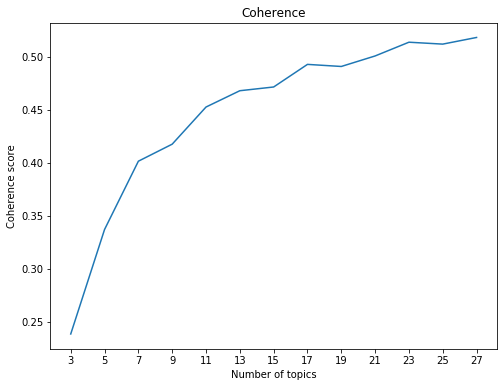

In [15]:
pd.DataFrame(comparison).plot('k','coherence', title = 'Coherence', legend = False, figsize = (8, 6))
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.xticks(range(3, 29, 2))
plt.show()

#### Load the best model:

In [207]:
PATH_MODELS = os.path.join(PATH, 'results/topics/mallet')
mallet = ldamallet.LdaMallet.load(os.path.join(PATH_MODELS, 'lda_21'))
mallet = ldamallet.malletmodel2ldamodel(mallet)

### Evaluation

#### Visualize topic map using `LDAvis`

In [214]:
#visualize topics
PATH_VIS = os.path.join(PATH_MODELS, 'mallet_vis.html')
if os.path.isfile(PATH_VIS):
    display(HTML(open(PATH_VIS, 'r').read()))
else:
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(mallet, corpus, id2word, sort_topics = False)
    pyLDAvis.save_html(vis, PATH_VIS)
    vis

In [46]:
topic_dict = {1:'aggression (?)',
          2:'coronavirus',
          3:'lockdown',
          4:'foreign affairs',
          5:'writing',
          6:'work (?)',
          7:'political parties',
          8:'media',
          9:'help(?)',
          10:'justice/rule of law',
          11:'finance',
          12:'religion',
          13:'electoral procedure',
          14:'elections',
          15:'greetings',
          16:'history/ww2',
          17:'unk3',
          18:'rule of law/constitution',
          19:'presidential candidates',
          20:'people (?)',
          21:'staying at home (?)'}
json.dump(topic_dict, open(os.path.join(PATH_MODELS, 'best_model_topic_dict.json'), 'w'))

#### Predict topics for the entire corpus
- Create a json dictionary mapping Tweet ids to cluster labels.

In [8]:
PATH_TOPICS = os.path.join(PATH_MODELS, 'best_model_topics.json')
if os.path.isfile(PATH_TOPICS):
    topic_map = json.load(open(PATH_TOPICS, 'r'))
else:
    topic_map = dict()
    for dat in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, dtype = dtypes, filter_fun = ff, method = 'pandas')):
        lemmas = dat.lemmatized.apply(lambda x: [w for w in x.split() if w not in stopwords]).tolist() #get list
        texts = [id2word.doc2bow(t) for t in lemmas] #get bow representation
        topics = evaluation.lda_predict(mallet, texts) #predict topics
        topic_map.update(dict(zip(dat.id_str.tolist(), topics))) #store topics
    json.dump(topic_map, open(PATH_TOPICS, 'w'))

### Vocabulary distribution in each topic:

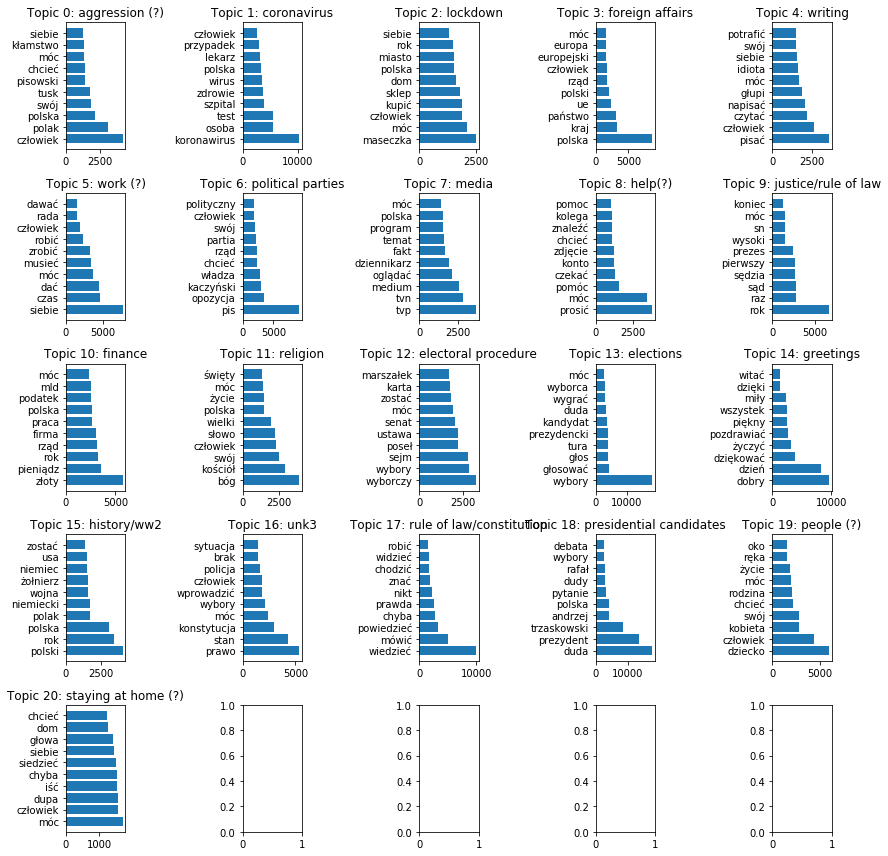

In [26]:
data['topic'] = data['id_str'].map(topic_map)
topics = sorted(np.unique(list(topic_map.values())))
side = int(np.ceil(np.sqrt(len(topics))))
fig, ax = plt.subplots(side, side, figsize = (12, 12))
ax = ax.ravel()
for i, topic in tqdm(enumerate(topics)):
    tmp = data[data['topic'] == topic].lemmatized
    fd = FreqDist(chain.from_iterable(tmp))
    common_tokens = fd.most_common(10)
    ax[i].barh([w[0] for w in common_tokens], [w[1] for w in common_tokens])
    ax[i].set_title(f'Topic {i}: {topic_dict[i+1]}')
plt.tight_layout()
plt.show()

### Temporal distribution of each topic

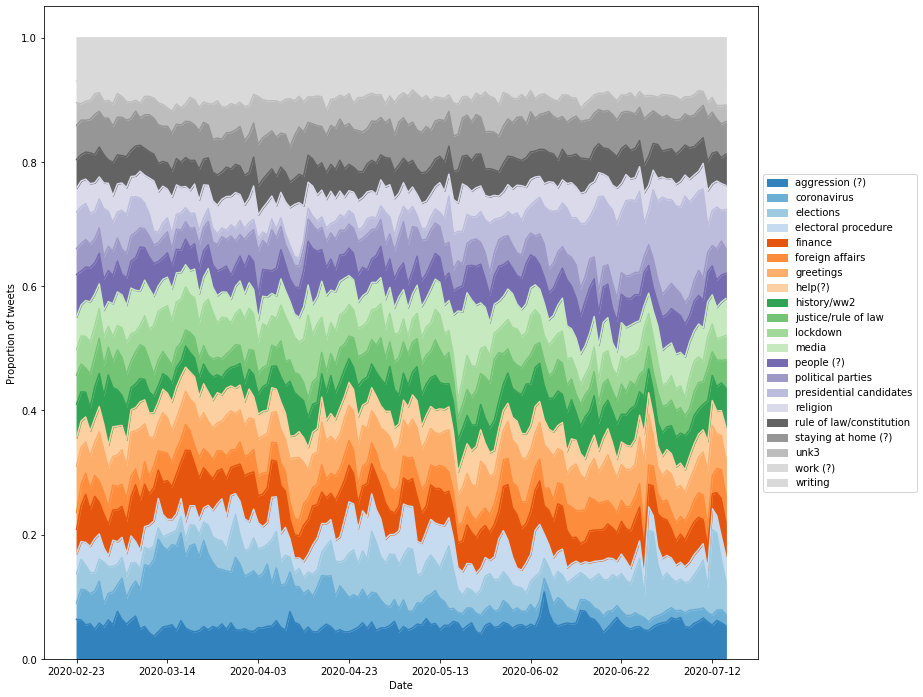

In [149]:
topic_subset = None
aggregate = data.groupby(['topic','day']).size().reset_index().rename(columns = {0:'num'}) #get counts by day and topic
daycounts = aggregate.groupby('day').agg({'num':np.sum})['num'] #get counts by day for normalization
aggregate['num'] = aggregate['num'].div(aggregate['day'].map(daycounts)) #normalize count
if topic_subset is not None:
    aggregate = aggregate[aggregate['topic'].isin(topic_subset)]
aggregate['topic'] = aggregate.topic.map(topic_dict).astype(str) #convert topics to names
aggregate = aggregate.pivot(index = 'day', columns = 'topic', values = 'num') #reshape
#plot
fig, ax = plt.subplots(1, 1, figsize = (16, 12))
aggregate.plot.area(ax = ax, cmap = 'tab20c')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_ylabel('Proportion of tweets')
ax.set_xlabel('Date')

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [150]:
def plot_dists(topics, sources, topic_subset:list = None, 
               topic_dict:dict = None, **kwargs):
    """
    Function to plot token distributions of the clusters.
    """
    
    #prepare plot
    fig, ax = plt.subplots(2, 1, **kwargs)
    ax = ax.ravel()
    
        
    if topic_dict is not None:
        topics = topics.astype(str) + " : " + np.vectorize(topic_dict.get)(topics)
        
    
    
    #OVERALL DISTRIBUTION
    tab = pd.value_counts(topics, normalize = True)
    tab.plot.bar(ax = ax[0], cmap = 'tab20c')
    #get mapping for the next plot:
    mapping = {k:i for i, (k, v) in enumerate(sorted(tab.items(), key = lambda x: x[1], reverse = True))}
    ax[0].axes.get_xaxis().set_visible(False)
    
    
    
    #BETWEEN-PARTY DISTRIBUTION
    crosstab = pd.crosstab(topics, sources, normalize = "index")
    #order according to size:
    key = crosstab.reset_index().topic.map(mapping)
    crosstab = crosstab.iloc[key.argsort()]
    crosstab.plot.bar(ax = ax[1], stacked = True, cmap = 'tab20c')
    if topic_dict is None:
        ax[1].set_xlabel("Topic number")
    else:
        ax[1].set_xlabel("Topic title")
    ax[1].legend(["Government", "Opposition"])
    
    #label
    font = {'size': 18}
    fig.text(-0.01, 0.5, 'Propotion of tweets', va='center', rotation='vertical', fontdict = font)
    #show
    plt.tight_layout()
    plt.show()

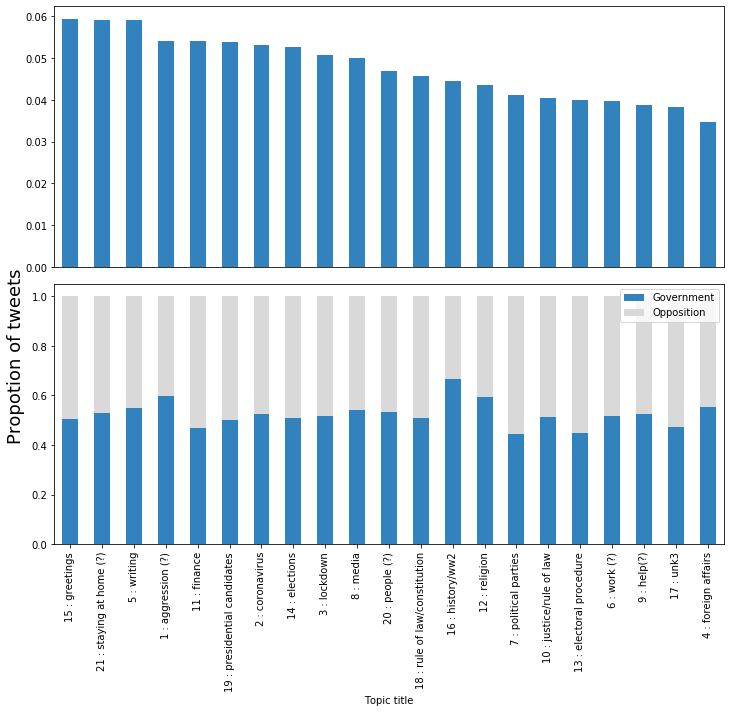

In [151]:
data = data.reset_index(drop = True)
plot_dists(data['topic'], data['source'], figsize = (10, 10), topic_dict = topic_dict)

### Odds of belonging to the parties given a topic:

In [178]:
from sklearn.linear_model import LogisticRegression
res = dict()
for df in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, dtype = dtypes, filter_fun = ff, method = 'pandas')):
    df['topic'] = df['id_str'].map(topic_map).astype(int)
    if df['topic'].isna().any():
        continue
    day = df['day'].unique()[0]
    res[day] = df.groupby(['topic']).apply(lambda x: LogisticRegression(fit_intercept = False).fit(np.ones(x.shape[0])[:,np.newaxis], 
                                                                                                   np.where(x['source'] == 'gov', 1, 0)).coef_[0][0])
    glm = LogisticRegression(fit_intercept = False)
    glm.fit(X, Y)
res = pd.DataFrame.from_dict(res)
res = res.reset_index().melt('topic')
res['topic_name'] = res['topic'].map(topic_dict)

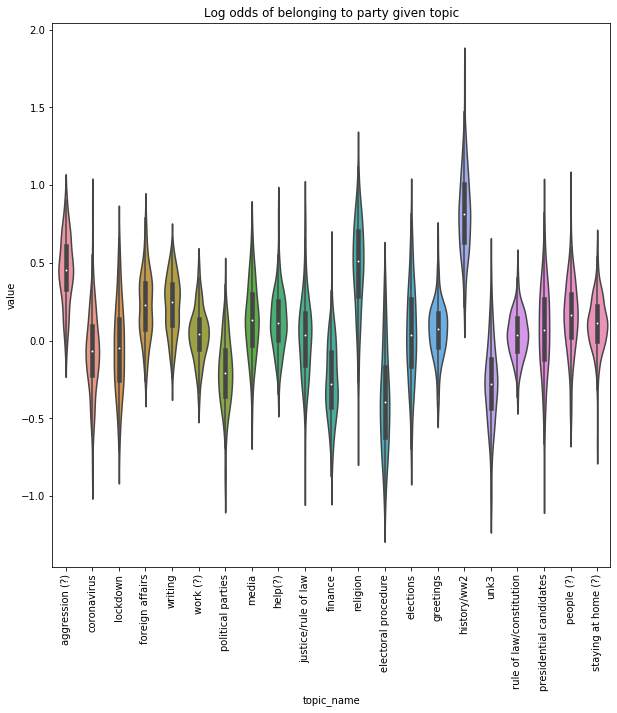

In [200]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
sns.violinplot(x = 'topic_name', y = 'value', data = res, ax = ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_title('Log odds of belonging to government based on the topic')
plt.show()